In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2
from torch.utils.data import DataLoader
from torchvision import datasets
import pycocotools
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
from matplotlib.patches import Rectangle   
import random
from PIL import Image
from ultralytics import YOLO
import math
import torchvision.models.detection as detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim

In [2]:
train_dataset_path = 'Dataset/train2017'
test_dataset_path  = 'Dataset/val2017'

In [3]:
# image = (image - mean) / std
mean = [0.4701, 0.4469, 0.4076]
std = [0.2330, 0.2280, 0.2315]

train_transforms = transforms.Compose ([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [4]:
train_dataset =  torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform  = test_transforms)

In [5]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size =6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([0, 0, 0, 0, 0, 0])


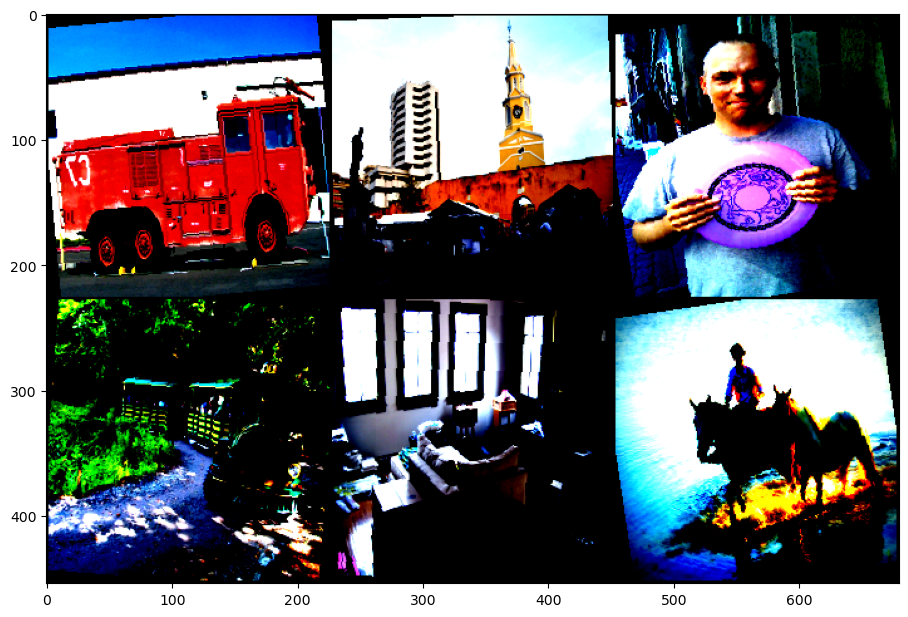

In [6]:
show_transformed_images(train_dataset)

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [32]:
def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)

In [37]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    for epoch in range(n_epochs):
        print(f"Epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0
        running_correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct/total
        print(f"    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss,))
        
        checkpoint_filename = f'model_checkpoint_epoch_{epoch + 1}.pt'
        save_checkpoint(model, optimizer, epoch, epoch_loss, checkpoint_filename)
        evalate_model_on_test_set(model, test_loader)
    print("Finished")
    return model

In [38]:
def evalate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    print(f"    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
          % (predicted_correctly_on_epoch, total, epoch_acc))

In [16]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 80
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [39]:
train_nn(resnet18_model, train_loader, test_loader, criterion, optimizer, 10)

Epoch number 1
    - Training dataset. Got 118287 out of 118287 images correctly (100.000%). Epoch loss: 0.002
    - Testing dataset. Got 5000 out of 5000 images correctly (100.000%)
Epoch number 2
    - Training dataset. Got 118287 out of 118287 images correctly (100.000%). Epoch loss: 0.002
    - Testing dataset. Got 5000 out of 5000 images correctly (100.000%)
Epoch number 3
    - Training dataset. Got 118287 out of 118287 images correctly (100.000%). Epoch loss: 0.002
    - Testing dataset. Got 5000 out of 5000 images correctly (100.000%)
Epoch number 4
    - Training dataset. Got 118287 out of 118287 images correctly (100.000%). Epoch loss: 0.002
    - Testing dataset. Got 5000 out of 5000 images correctly (100.000%)
Epoch number 5
    - Training dataset. Got 118287 out of 118287 images correctly (100.000%). Epoch loss: 0.002
    - Testing dataset. Got 5000 out of 5000 images correctly (100.000%)
Epoch number 6
    - Training dataset. Got 118287 out of 118287 images correctly (100

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
new_test_set_path = 'Dataset/test2017'

In [41]:
new_test_dataset = torchvision.datasets.ImageFolder(root = new_test_set_path, transform  = test_transforms)

In [42]:
new_test_loader = torch.utils.data.DataLoader(new_test_dataset, batch_size=128, shuffle=False)

In [44]:
evalate_model_on_test_set(resnet18_model, new_test_loader)

    - Testing dataset. Got 40670 out of 40670 images correctly (100.000%)
